In [40]:
import logging
import os
import sys
import shutil
import tempfile
import argparse
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    SpatialPad,
    RandFlip,
    RandZoom,
    AsDiscrete,
)
import math
import nrrd
from monai.metrics import ConfusionMatrixMetric
from sklearn.model_selection import KFold
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch.nn as nn
import time
import torch.multiprocessing
from utils import get_model, SmoothCrossEntropyLoss, draw_confusion_graph, FocalLossCrossEntropyLoss, draw_auc_graph

In [41]:
torch.multiprocessing.set_sharing_strategy('file_system')
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [42]:
data_directory = '/home/tianyu/Desktop/data_base/imagesTr_cropped'
label_directory = '/home/tianyu/Desktop/data_base/labels.csv'

In [43]:
# load image
images = [os.path.join(data_directory, f) for f in sorted(os.listdir(data_directory)) if f.endswith('.nii.gz')]
images = np.array(images)
print(f'images directory found, print 5 images name:\n {images[0:5]}')

# load label
df = pd.read_csv(label_directory)  # label directory
labels = df['label']
labels.replace({'B': 0, 'M': 1}, inplace=True)
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()
labels = np.array(labels)
print(f'label directory found, print 5 labels value:\n {labels[0:5]}')

images directory found, print 5 images name:
 ['/home/tianyu/Desktop/data_base/imagesTr_cropped/testSec_001.nii.gz'
 '/home/tianyu/Desktop/data_base/imagesTr_cropped/testSec_002.nii.gz'
 '/home/tianyu/Desktop/data_base/imagesTr_cropped/testSec_003.nii.gz'
 '/home/tianyu/Desktop/data_base/imagesTr_cropped/testSec_004.nii.gz'
 '/home/tianyu/Desktop/data_base/imagesTr_cropped/testSec_005.nii.gz']
label directory found, print 5 labels value:
 [[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


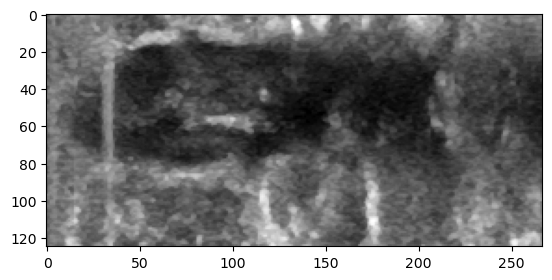

In [44]:
# test loading data
import nibabel as nib
# 加载 nii.gz 文件
test_img = nib.load(images[0])
# 获取数据并转换为 NumPy 数组
test_data = test_img.get_fdata()
slice_index = test_data.shape[2] // 2
slice_2d = test_data[:, :, slice_index]
plt.imshow(slice_2d, cmap='gray')
plt.show()

In [45]:
# define tranforms

padsize = 128
resize = 128

train_transforms = Compose(
        [ScaleIntensity(), EnsureChannelFirst(),
         # RandRotate90(prob=0.1),  # 10%的概率随机旋转90度
         RandFlip(spatial_axis=0, prob=0.1),  # 10%的概率进行随机翻转
         RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.1),  # 10%的概率进行随机缩放
         SpatialPad((padsize, padsize, padsize), mode='constant'),
         Resize((resize, resize, resize))])

val_transforms = Compose(
        [ScaleIntensity(), EnsureChannelFirst(),
         SpatialPad((padsize, padsize, padsize), mode='constant'),
         Resize((resize, resize, resize))])    

64


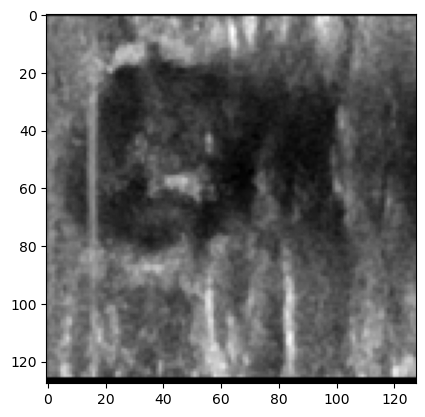

In [46]:
test_ds = ImageDataset(image_files=images, labels=labels, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=6, pin_memory=pin_memory)
for batch_data in test_loader:
    inputs_cuda = batch_data[0].to(device)
    # 提取第一个3D图像
    image3d = inputs_cuda[0, 0].cpu().numpy()

    # 提取一个切片，例如中间的切片
    slice_index = image3d.shape[2] // 2
    print(slice_index)
    slice_2d = image3d[:, :, slice_index]

    # 使用 matplotlib 展示这个切片
    plt.imshow(slice_2d, cmap='gray')
    plt.show()
    break
